# AIBE Project: Polyp segmentation using UNET
## 1. Importing libraries, data and functions
### 1.1. Importing packages and setting directories

In [1]:
# importing necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
import random
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Lambda, RepeatVector, Reshape, Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D,concatenate, add, Lambda, RepeatVector, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD, schedules, Adam
from tensorflow.python.keras import losses

# Defining personal path for importing the dataset
dpath = "/Users/marcalbesa/Desktop/AIBE (IA)/projecte ia/PolypLocalizationDataset/PolypLocalizationDataset"
out_path = "/Users/marcalbesa/Desktop/AIBE (IA)/projecte ia/outputs"

image_list_kvasir = os.listdir(os.path.join(dpath, 'Kvasir-SEG/images'))
mask_list_kvasir = os.listdir(os.path.join(dpath, 'Kvasir-SEG/masks'))

image_list_clinicdb = os.listdir(os.path.join(dpath, 'CVC-ClinicDB/images'))
mask_list_clinicdb = os.listdir(os.path.join(dpath, 'CVC-ClinicDB/masks'))

image_list_colondb = os.listdir(os.path.join(dpath, 'CVC-ColonDB/images'))
mask_list_colondb = os.listdir(os.path.join(dpath, 'CVC-ColonDB/masks'))

image_list_etis = os.listdir(os.path.join(dpath, 'ETIS-LARIB/images'))
mask_list_etis = os.listdir(os.path.join(dpath, 'ETIS-LARIB/masks'))
total_images_len = len(image_list_kvasir+image_list_clinicdb+image_list_colondb+image_list_etis)
print("Total number of images: ", total_images_len)

Total number of images:  2188


### 1.2. Defining functions

In [2]:
# Defining a custom precprocessing function
def preprocessImage(image_list_db, image_list, mask_list, path, display):
    display =display
    for img_name in image_list_db:

        image_path = os.path.join(dpath,path,'images', img_name)
        if path == 'ETIS-LARIB':
            mask_path = os.path.join(dpath,path,'masks', "p"+img_name)
        else:
            mask_path = os.path.join(dpath,path,'masks', img_name)

        if display:
            img = mpimg.imread(image_path)
            imgplot = plt.imshow(img)
            plt.show()

            img = mpimg.imread(mask_path)
            imgplot = plt.imshow(img, cmap ="gray")
            plt.show()
            display = False

        #reshape to (ch,im_height,im_width)
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = np.round(cv2.resize(x, (image_height, image_width)))
        x.dtype = np.uint8
        y = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        y = cv2.resize(y, (image_height, image_width))

        # Normalization
        x= x/255.0
        y= y/255.0

        # Appends to the lists the images
        image_list.append(x)
        mask_list.append(y)

        if len(image_list)%200 == 0:
            print(len(image_list), 'done')

    return image_list, mask_list

# defining dice coefficient metric
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

# defining dice loss funciton
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

# defining binary_crossentropy + dice loss
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

## 2. Preprocessing the data
### 2.1. Preprocess images from the different directories

In [3]:
#adding channel dimensions
image_height = 256
image_width = 256

# creating empty lists for storing images
images = []
masks = []

# preprocessing images
images, masks =  preprocessImage(image_list_kvasir,images, masks, 'Kvasir-SEG', False)
images, masks =  preprocessImage(image_list_clinicdb,images, masks, 'CVC-ClinicDB', False)
images, masks =  preprocessImage(image_list_colondb,images, masks, 'CVC-ColonDB', False)
images, masks =  preprocessImage(image_list_etis,images, masks, 'ETIS-LARIB', False)

# printing dimensions
print(len(images), len(masks))
masks =  np.expand_dims(masks, -1) # adding batch dimension
masks.shape
images = np.array(images)
images.shape

# performing train and test split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.1, random_state=42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

# clear the lists
images = []
masks = []

# clear the current keras session
tf.keras.backend.clear_session() # Clear the current keras session

200 done
400 done
600 done
800 done
1000 done
1200 done
1400 done
1600 done
1800 done
2000 done
2188 2188
1969 1969 219 219


### 2.2. Performing Data Augmentation

Horizontal Shift (-100,100)
Vertical Shift (-150,150)
Horizontal Flip
Brighness [0.2,1.0]
Zoom [0.3/0.4, 1.0]

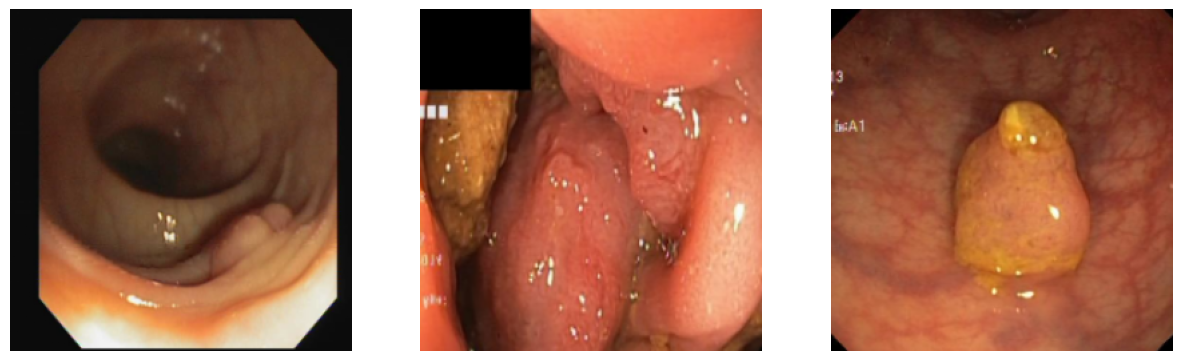

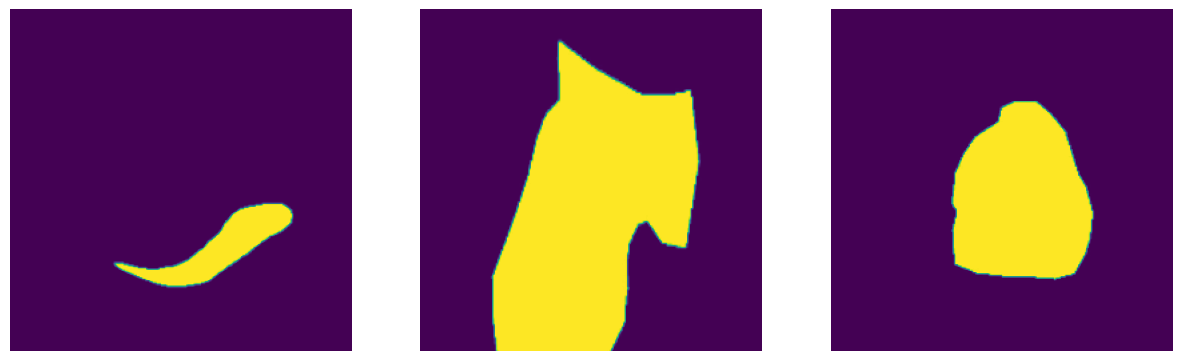

In [4]:
# creating a dictionary with the parameters to send to ImageDataGenerator
data_gen_args = dict(
    #rotation_range=60,
    zoom_range=[0.6,1.0],
    #width_shift_range=[-50,50],
    #height_shift_range=[-50,50],
    #brightness_range = [0.3, 0.5],
    #horizontal_flip=True,
    vertical_flip = True,
    fill_mode="nearest",)

# Creating two models for data augmentation, both for images and masks
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# set seed for reproducibility
seed = 1

# fit the generator model for both train and test
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

# performing data augmentation with data_generator.flow
image_generator = image_datagen.flow(X_train, batch_size = 32, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size = 32, seed=seed)

# plotting 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for i in range(3):
    image = next(image_generator)[0]
    ax[i].imshow(image)
    ax[i].axis('off')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for i in range(3):
    image = next(mask_generator)[0]
    ax[i].imshow(image)
    ax[i].axis('off')

# creating a tuple for training
train_generator = zip(image_generator, mask_generator)

# clear the current keras session
tf.keras.backend.clear_session()

## 3. Training the model
### 3.1. Defining UNET arquitecture

In [5]:
# Defining structure of a convolutional block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

# defining the structure of the UNET and the model
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

### 3.2. Compiling the model and selecting hyperparameters

In [6]:
# defining the placeholder for the input
input_img = Input((image_height, image_width, 3), name='img')

# calling the model and plotting summary
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.summary()

# compiling the model
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[dice_loss, dice_coeff, 'accuracy'])

# defining model callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

# defining hyperparameters
batch_size = 32
epochs = 50

2024-05-12 22:48:42.219534: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-05-12 22:48:42.219826: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-12 22:48:42.219830: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-12 22:48:42.221060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-12 22:48:42.222136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 256, 256, 16)         448       ['img[0][0]']                 
                                                                                                  
 batch_normalization_2 (Bat  (None, 256, 256, 16)         64        ['conv2d_2[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_2 (Activation)   (None, 256, 256, 16)         0         ['batch_normalization_2[0]

### 3.3. Fitting the model

In [7]:
# fitting the model
results = model.fit(train_generator, batch_size=batch_size, steps_per_epoch=int(np.ceil(len(X_train) / float(batch_size))),
                    epochs=epochs, callbacks=callbacks, validation_data=(X_test, y_test), verbose = 1)

Epoch 1/50


2024-04-30 08:56:24.143169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - ETA: 0s - loss: 0.5594 - dice_loss: 0.7331 - dice_coeff: 0.2669 - accuracy: 0.7352

2024-04-30 08:57:06.784652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.60126, saving model to model-checkpoint.h5
62/62 [==============================] - 45s 638ms/step - loss: 0.5594 - dice_loss: 0.7331 - dice_coeff: 0.2669 - accuracy: 0.7352 - val_loss: 0.6013 - val_dice_loss: 0.8056 - val_dice_coeff: 0.1944 - val_accuracy: 0.7079 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.4271 - dice_loss: 0.7405 - dice_coeff: 0.2595 - accuracy: 0.8251
Epoch 2: val_loss improved from 0.60126 to 0.45049, saving model to model-checkpoint.h5
62/62 [==============================] - 48s 769ms/step - loss: 0.4271 - dice_loss: 0.7405 - dice_coeff: 0.2595 - accuracy: 0.8251 - val_loss: 0.4505 - val_dice_loss: 0.7857 - val_dice_coeff: 0.2143 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.3905 - dice_loss: 0.7153 - dice_coeff: 0.2847 - accuracy: 0.8311
Epoch 3: val_loss improved from 0.45049 to 0.41151, saving model to model-checkpoint.h5

### 3.4. Plotting learning curves

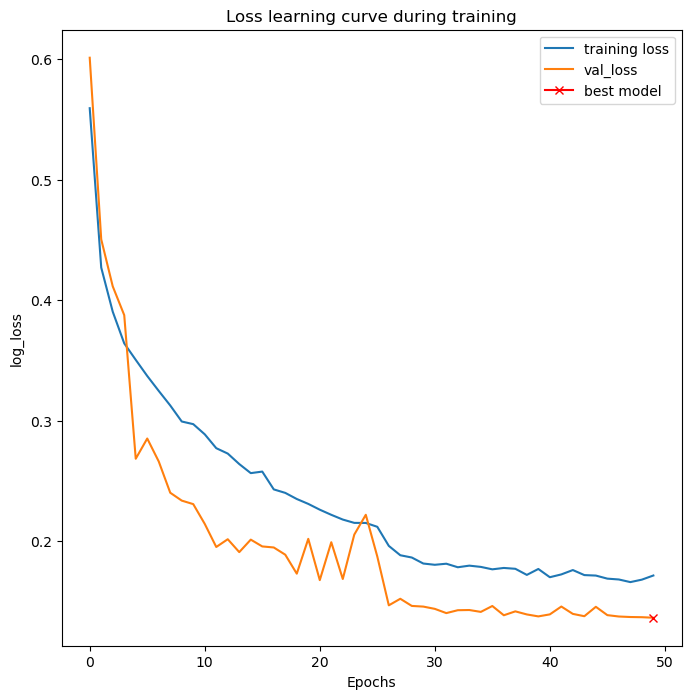

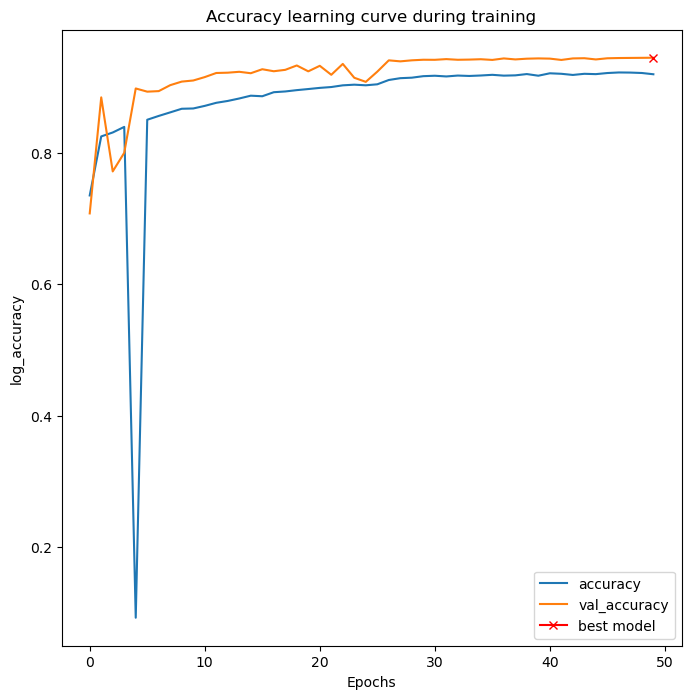

In [8]:
# plotting loss learining curve
plt.figure(figsize=(8, 8))
plt.title("Loss learning curve during training")
plt.plot(results.history["loss"], label="training loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

# plotting accuracy learining curve
plt.figure(figsize=(8, 8))
plt.title("Accuracy learning curve during training")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_accuracy")
plt.legend()

## 4. Evaluating model performance

2024-05-12 22:48:45.171844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 3s 194ms/step - loss: 0.1364 - dice_loss: 0.3500 - dice_coeff: 0.6500 - accuracy: 0.9449


2024-05-12 22:49:27.882503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 138ms/step


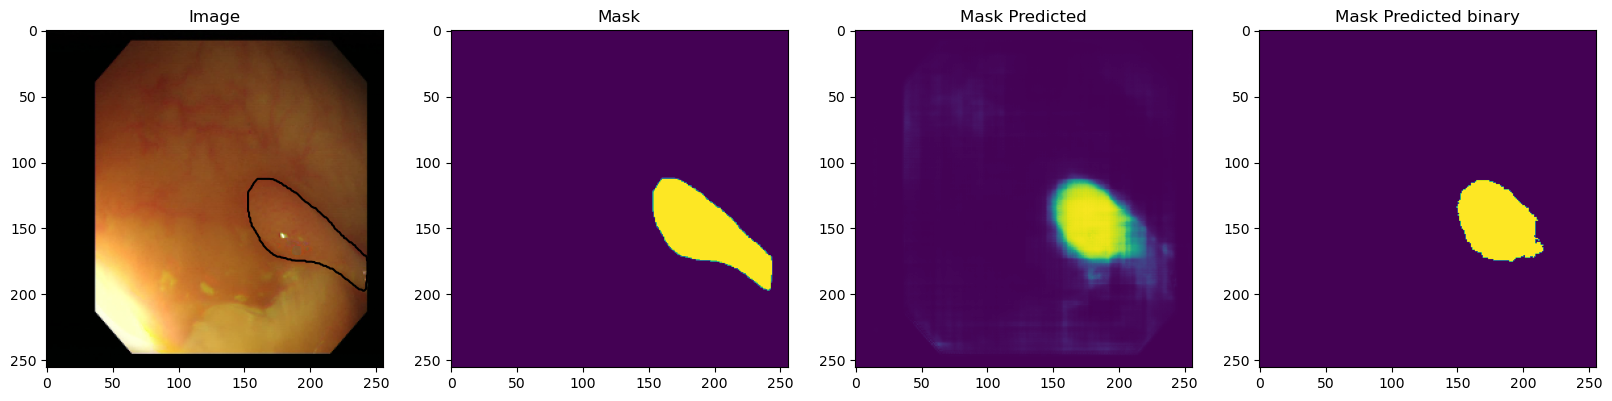

In [7]:
# loading stored weights and performing model evaluation
model.load_weights('/Users/marcalbesa/Desktop/AIBE (IA)/projecte ia/model-checkpoint.h5')
model.evaluate(X_test, y_test, verbose=1)

# predicting on the train and test datasets
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

# binarizing the predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# plotting the results
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Mask Predicted')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Mask Predicted binary');
    plt.savefig(os.path.join(out_path,"results.png"))
    plt.show()

plot_sample(X_test, y_test, preds_val, preds_val_t)

## 5. Possible causes of wrong predictions

In [8]:
from skimage.metrics import structural_similarity as ssim

# predicting on the train and test datasets
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

# binarizing the predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

7/7 [==============================] - 1s 167ms/step


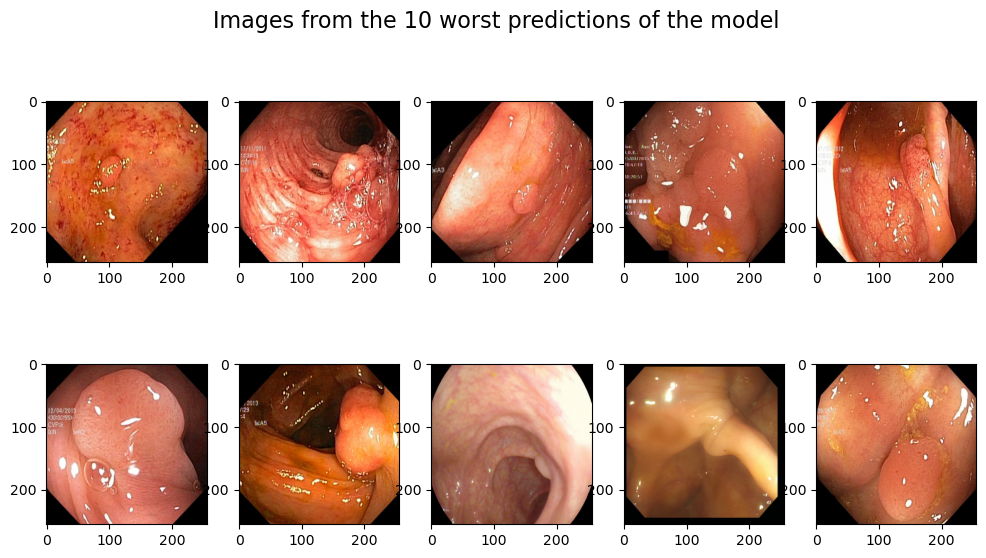

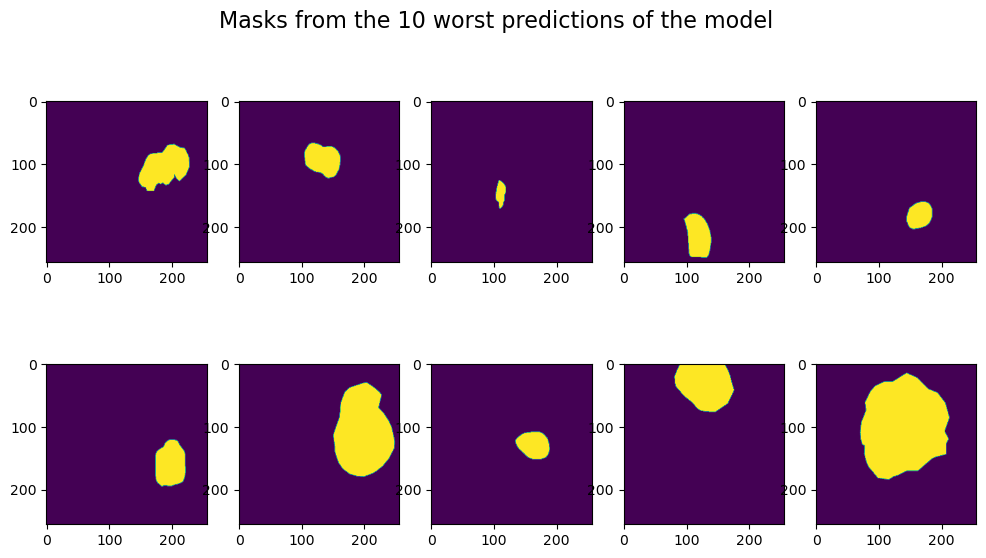

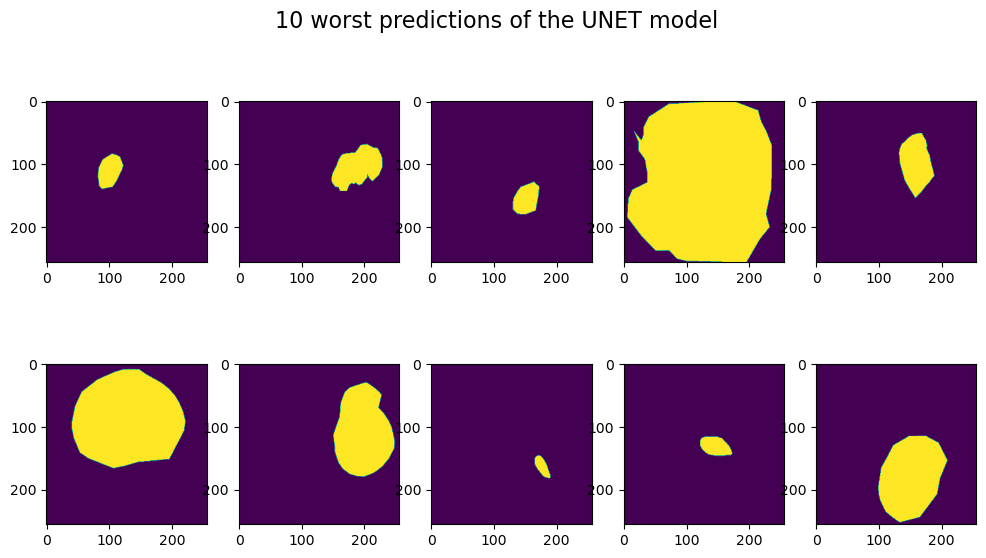

In [63]:
ssims = list()

# Loop through the images
for i in range(len(y_test)):
    # Compute SSIM between the i-th image in preds_val and y_test
    similarity = ssim(preds_val[i].squeeze(), y_test[i].squeeze(), data_range=1)
    ssims.append(similarity)

worst_indexs = list()
worst_images = list()
for i in range(10):
    index_of_min = np.argmin(ssims)
    worst_indexs.append(index_of_min)
    worst_images.append(y_test[index_of_min])
    ssims[index_of_min] = 1

fig, axs = plt.subplots(2, 5, figsize=(12,6))
plt.subplots_adjust(top=0.85, bottom=0.1, hspace=0.4)

axs[0,0].imshow(X_test[worst_indexs[0]])
axs[0,1].imshow(X_test[worst_indexs[1]])
axs[0,2].imshow(X_test[worst_indexs[2]])
axs[0,3].imshow(X_test[worst_indexs[3]])
axs[0,4].imshow(X_test[worst_indexs[4]])
axs[1,0].imshow(X_test[worst_indexs[5]])
axs[1,1].imshow(X_test[worst_indexs[6]])
axs[1,2].imshow(X_test[worst_indexs[7]])
axs[1,3].imshow(X_test[worst_indexs[8]])
axs[1,4].imshow(X_test[worst_indexs[9]])
fig.suptitle("Images from the 10 worst predictions of the model", fontsize=16)  # Add title for the entire plot
plt.savefig(os.path.join(out_path,"worst_predictions_images.png"))
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(12,6))
plt.subplots_adjust(top=0.85, bottom=0.1, hspace=0.4)

axs[0,0].imshow(y_test[0])
axs[0,1].imshow(y_test[1])
axs[0,2].imshow(y_test[2])
axs[0,3].imshow(y_test[3])
axs[0,4].imshow(y_test[4])
axs[1,0].imshow(y_test[5])
axs[1,1].imshow(y_test[6])
axs[1,2].imshow(y_test[7])
axs[1,3].imshow(y_test[8])
axs[1,4].imshow(y_test[9])
fig.suptitle("Masks from the 10 worst predictions of the model", fontsize=16)  # Add title for the entire plot
plt.savefig(os.path.join(out_path,"worst_masks.png"))
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(12,6))
plt.subplots_adjust(top=0.85, bottom=0.1, hspace=0.4)

axs[0,0].imshow(worst_images[0])
axs[0,1].imshow(worst_images[1])
axs[0,2].imshow(worst_images[2])
axs[0,3].imshow(worst_images[3])
axs[0,4].imshow(worst_images[4])
axs[1,0].imshow(worst_images[5])
axs[1,1].imshow(worst_images[6])
axs[1,2].imshow(worst_images[7])
axs[1,3].imshow(worst_images[8])
axs[1,4].imshow(worst_images[9])
fig.suptitle("10 worst predictions of the UNET model", fontsize=16)  # Add title for the entire plot
plt.savefig(os.path.join(out_path,"worst_predictions_masks.png"))
plt.show()

## 6. Assessing live performange of the model

Shape of the video array: (410, 256, 256, 3)
13/13 [==============================] - 2s 125ms/step


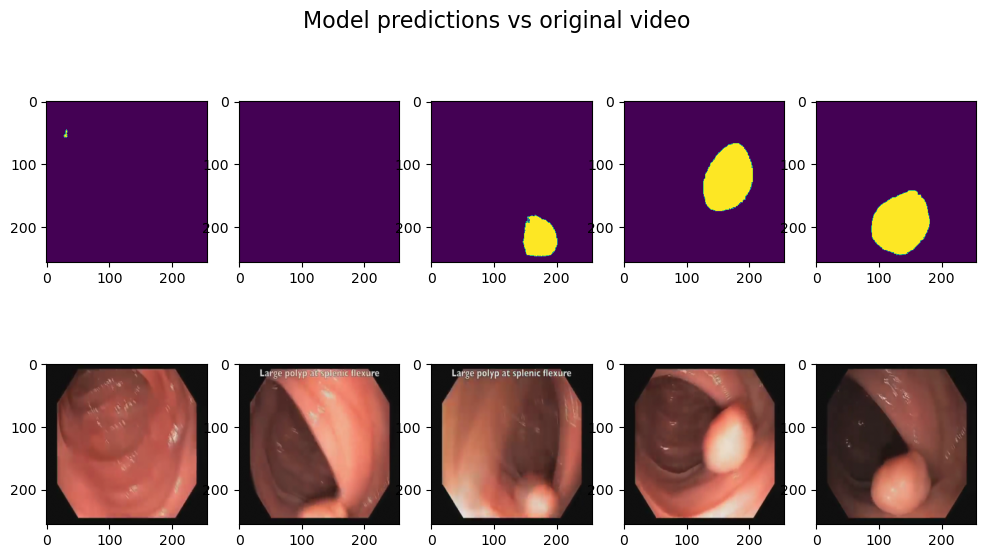

In [62]:
import cv2
import numpy as np

# Load the MP4 file
cap = cv2.VideoCapture('/Users/marcalbesa/Desktop/AIBE (IA)/projecte ia/polyp_video.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize an empty list to store frames
frames = []

# Read frames from the video until there are no more frames left
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # Append the frame to the list of frames
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_rgb = cv2.resize(frame_rgb, (image_height, image_width))
        frames.append(frame_rgb)
    else:
        break

# Convert the list of frames to a numpy array
video_array = np.array(frames)

# Close the video capture object
cap.release()

# Print the shape of the resulting 4D array
print("Shape of the video array:", video_array.shape)

# Passing the normalized predictions to the model
video_array = video_array/np.max(video_array)
preds = model.predict(video_array, verbose=1)

# binarizing the predictions
preds = (preds > 0.8).astype(np.uint8)

# Plotting
fig, axs = plt.subplots(2, 5, figsize=(12,6))
plt.subplots_adjust(top=0.85, bottom=0.1, hspace=0.4)
axs[0,0].imshow(preds[30])
axs[0,1].imshow(preds[170])
axs[0,2].imshow(preds[200])
axs[0,3].imshow(preds[130])
axs[0,4].imshow(preds[150])
axs[1,0].imshow(video_array[30])
axs[1,1].imshow(video_array[170])
axs[1,2].imshow(video_array[200])
axs[1,3].imshow(video_array[130])
axs[1,4].imshow(video_array[150])
fig.suptitle("Model predictions vs original video", fontsize=16)  # Add title for the entire plot
plt.savefig(os.path.join(out_path,"model_vs_video.png"))
plt.show()

# Superposing both images
for i in range(len(preds)):
    indices = np.where(preds[i] == 1)
    video_array[i, indices[0], indices[1], 0] = 1  # Set red channel to 255
    video_array[i, indices[0], indices[1], 1] = 1  # Set green channel to 255
    video_array[i, indices[0], indices[1], 2] = 0    # Set blue channel to 0

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter('output_video.mp4', fourcc, fps, (width, height))

# Loop through each frame and write it to the video
video_array = np.uint8(video_array*255)
for frame in video_array:
    # Convert frame to BGR
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    # Resize the frame to the original dimensions
    frame_bgr = cv2.resize(frame_bgr, (width, height))
    # Write the frame to the video
    output_video.write(frame_bgr)
    
# Release the video writer
output_video.release()